In [243]:
import time
import math
import numpy as np 
import pandas as pd
import statsmodels.api as sm
from termcolor import colored

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pylab import rcParams

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

## Load the dataset
All data include the last 10 years values, coming from yahoo finance

In [113]:
google = pd.read_csv('Data/GOOG.csv', index_col='Date', parse_dates=True)
apple = pd.read_csv('Data/AAPL.csv', index_col='Date', parse_dates=True)
microsoft = pd.read_csv('Data/MSFT.csv', index_col='Date', parse_dates=True)

In [114]:
dataset = {'google': google, 'apple': apple, 'microsoft': microsoft}

## Analysis
Analysis step of the project includes: 
1. Check for na
2. Correlation of closing and opening price
3. Attributes visualization
4. Show trend and seasonality

### NAs

In [115]:
[df.isna().sum() for _, df in dataset.items()]

[Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64]

### Correlation

There is a very high correlation between "Open" and "Close"

In [116]:
for name, df in dataset.items():
    print(f'Correlation for {name.upper()}: \n{df.corr().to_markdown()}')
    print(f"{'='}"*90)

Correlation for GOOGLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999818 |  0.999805 |  0.999576 |    0.999576 | -0.386879 |
| High      |  0.999818 |  1        |  0.999765 |  0.999801 |    0.999801 | -0.384601 |
| Low       |  0.999805 |  0.999765 |  1        |  0.999817 |    0.999817 | -0.390556 |
| Close     |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Adj Close |  0.999576 |  0.999801 |  0.999817 |  1        |    1        | -0.388067 |
| Volume    | -0.386879 | -0.384601 | -0.390556 | -0.388067 |   -0.388067 |  1        |
Correlation for APPLE: 
|           |      Open |      High |       Low |     Close |   Adj Close |    Volume |
|:----------|----------:|----------:|----------:|----------:|------------:|----------:|
| Open      |  1        |  0.999878 |  0.999854 |  0.999694 |    0.9996

### Attributes visualization

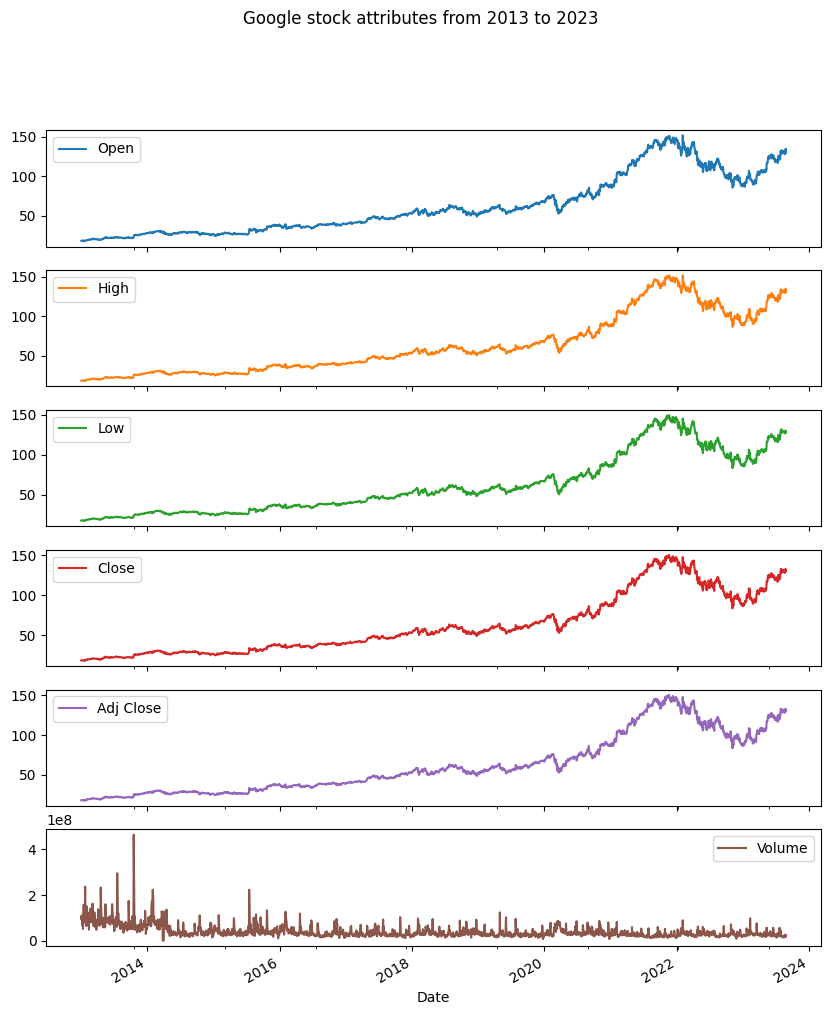

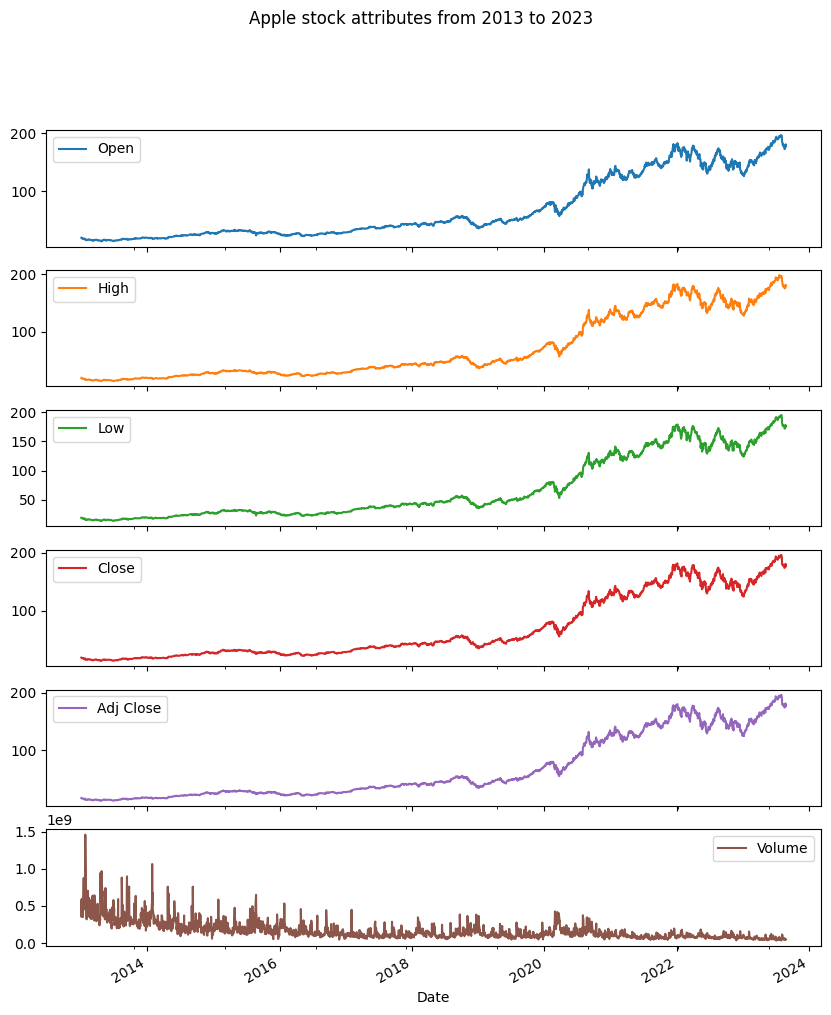

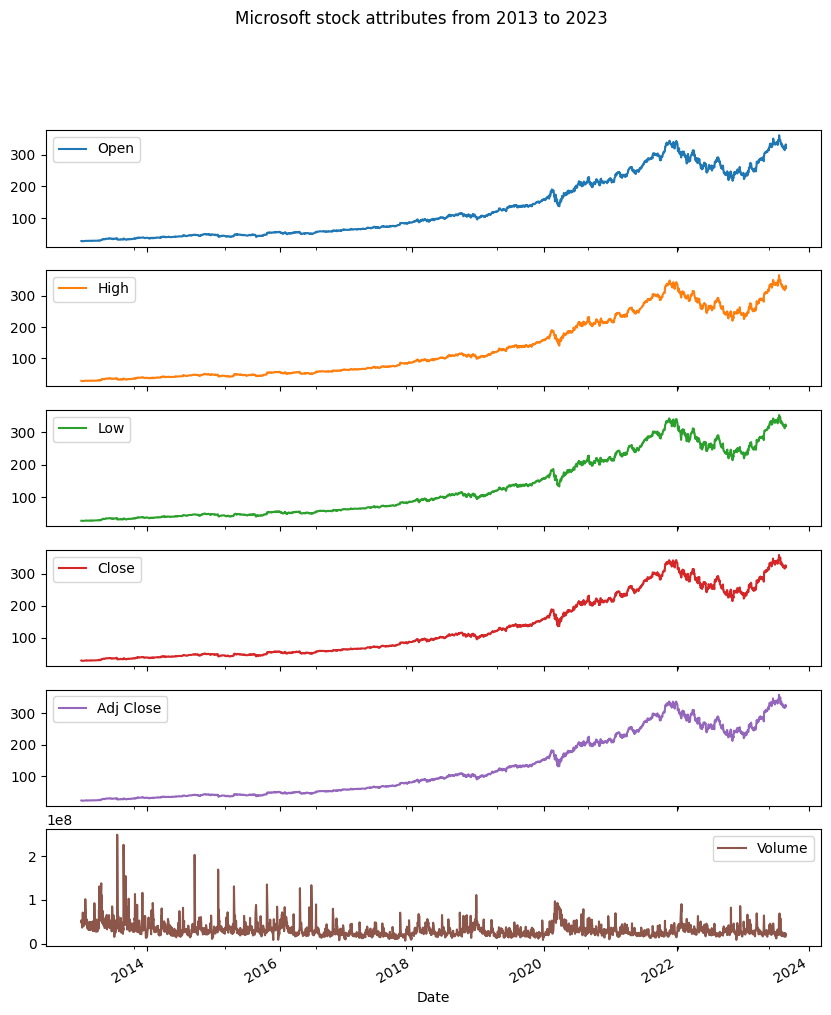

In [117]:
for name, df in dataset.items():
    df.plot(subplots=True, figsize=(10,12), title=f'{name.capitalize()} stock attributes from 2013 to 2023')
    plt.show()

#### High Plot

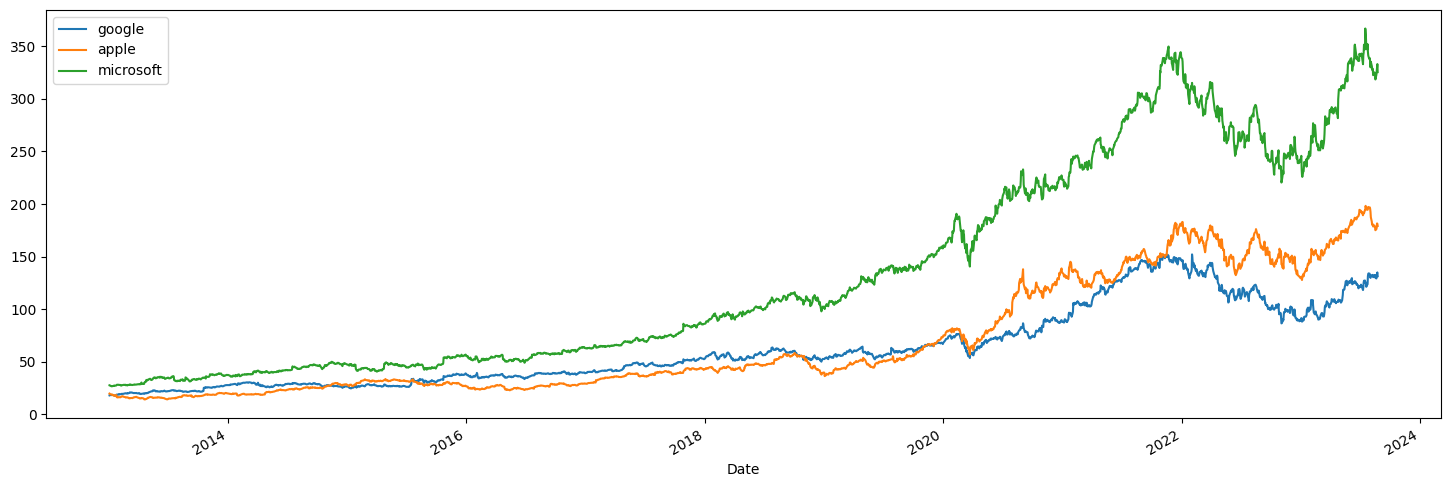

In [148]:
for _, df in dataset.items():
    df.High.plot()
plt.legend(dataset.keys())
plt.show()

#### Close Plot

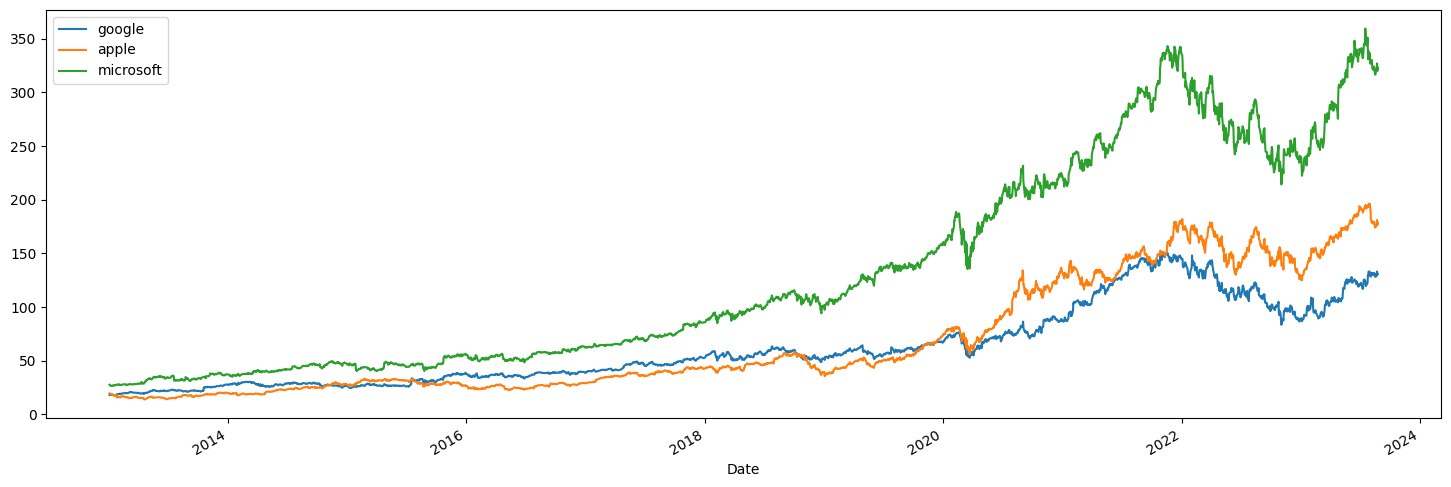

In [147]:
for _, df in dataset.items():
    df.Close.plot()
plt.legend(dataset.keys())
plt.show()

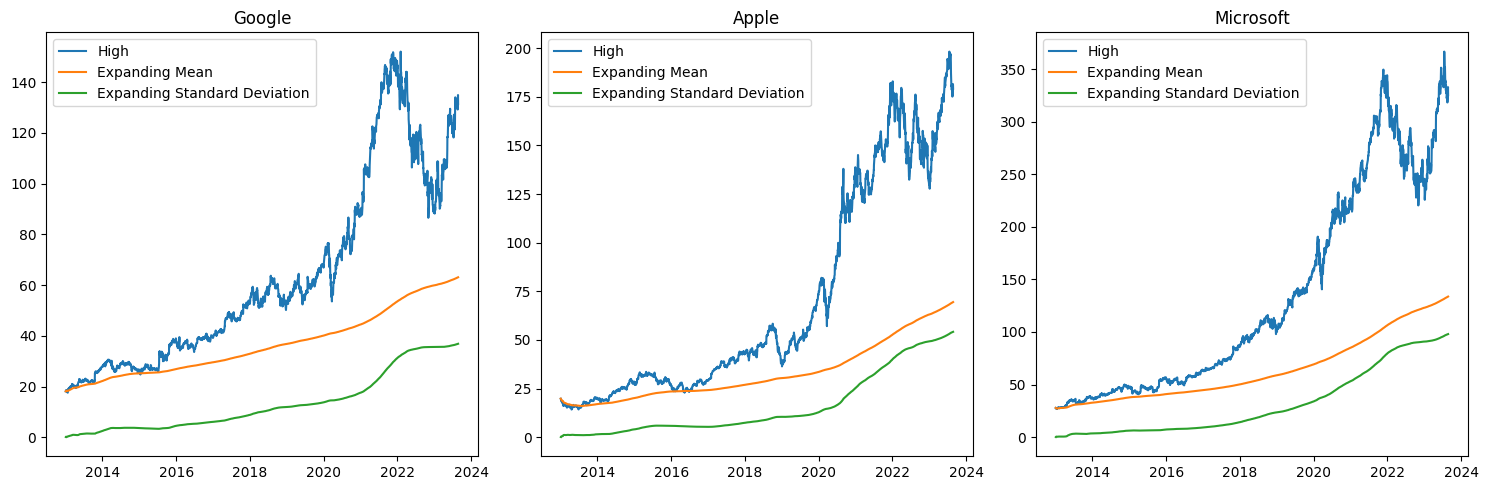

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Una riga e tre colonne

for i, data in enumerate(dataset):
    expanding_mean = dataset[data].High.expanding().mean()
    expanding_std = dataset[data].High.expanding().std()

    axs[i].plot(dataset[data].High, label='High')
    axs[i].plot(expanding_mean, label='Expanding Mean')
    axs[i].plot(expanding_std, label='Expanding Standard Deviation')
    
    axs[i].set_title(f'{data.capitalize()}')
    axs[i].legend()

plt.tight_layout()
plt.show()

"High" value was never under the mean for a long time after 2016, so we can say that they have gone very well until now. Their growth is exponential.
The little decrease step in 2016 may be caused by different social factors: 
- Brexit
- U.S. Elections (November)
- Central Bank Policies

### Trend and Seasonality

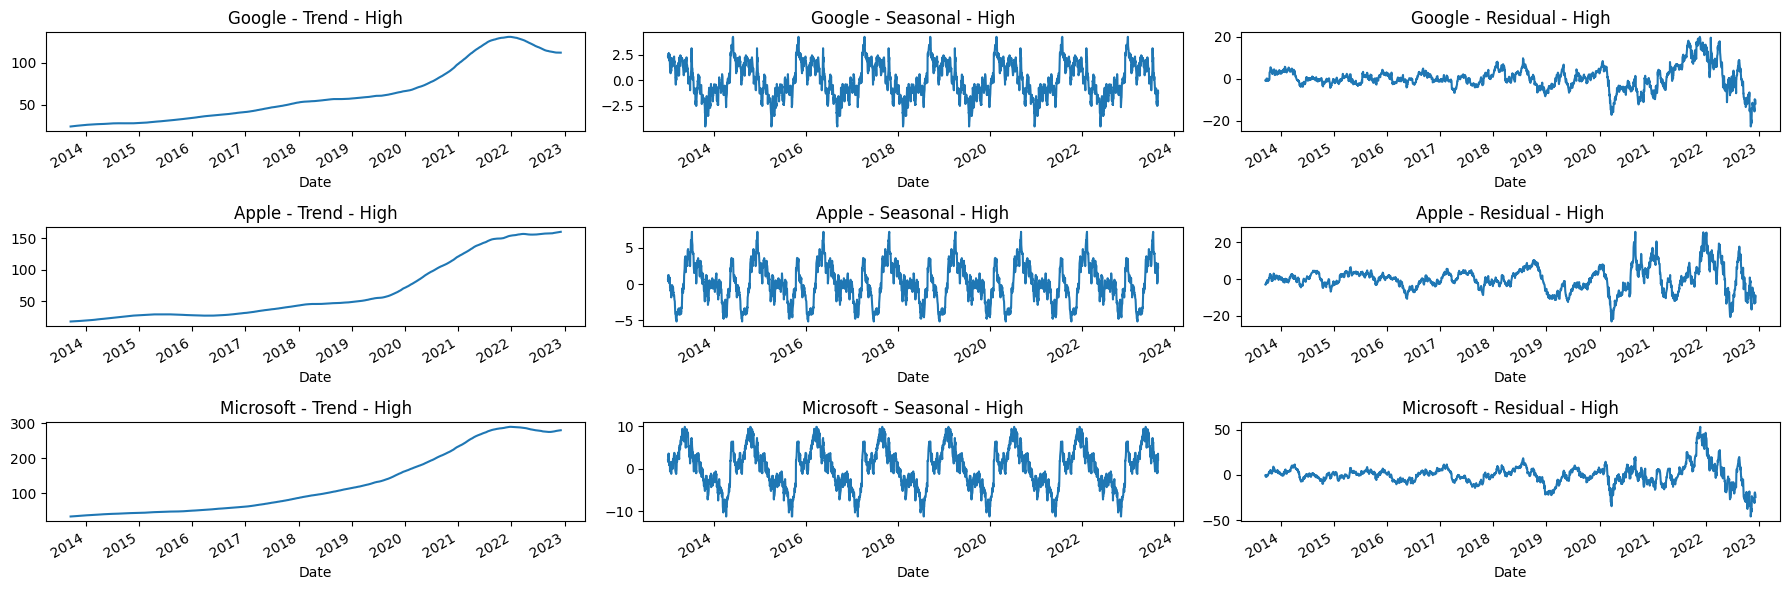

In [145]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["High"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - High")   
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - High")
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - High")
  
plt.tight_layout()
plt.show()

For all the 3 companies there is an exponential high trend after 2016 and a very high seasonality.

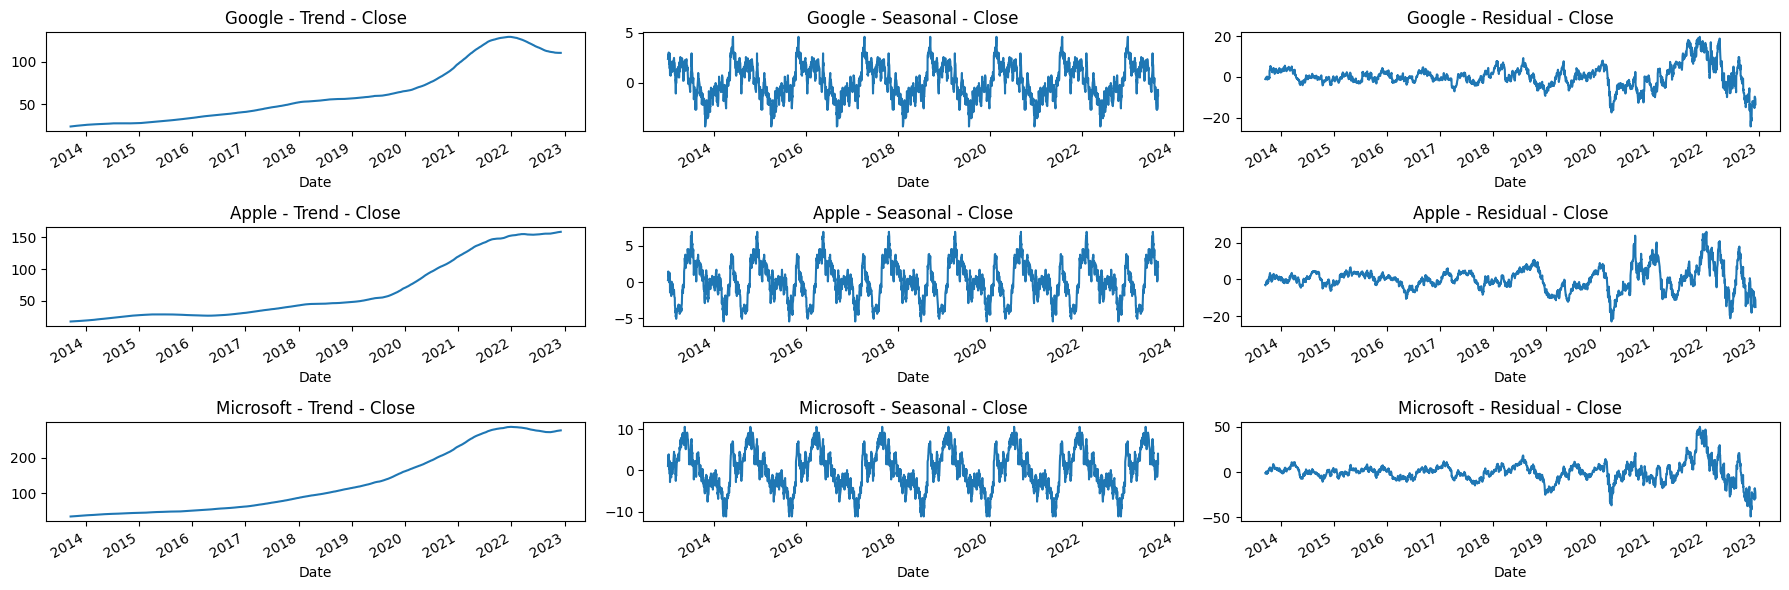

In [146]:
plt.rcParams['figure.figsize'] = 18, 6
fig, axes = plt.subplots(nrows=3, ncols=3)

for i, data in enumerate(dataset):
    ax_trend = axes[i, 0]
    ax_seasonal = axes[i, 1]
    ax_residual = axes[i, 2]
    
    decomposition = sm.tsa.seasonal_decompose(dataset[data]["Close"], period=360) # annual period
    decomposition.trend.plot(ax=ax_trend, title=f"{data.capitalize()} - Trend - Close")   
    decomposition.seasonal.plot(ax=ax_seasonal, title=f"{data.capitalize()} - Seasonal - Close")
    decomposition.resid.plot(ax=ax_residual, title=f"{data.capitalize()} - Residual - Close")
  
plt.tight_layout()
plt.show()

Since the correlation between Open and Close values is very high the trend and seasonality is very similar

## Time Series Forecasting
Time series forecasting uses information regarding historical data and use them to discover patterns to use to predict future activity. Most often, this relates to trend analysis, cyclical fluctuation analysis, and issues of seasonality. As with all forecasting methods, success is not guaranteed.

We will use a **GRU Model**

Gated recurrent unit is essentially a simplified LSTM. It has the exact same role in the network. The main difference is in the number of gates and weights — GRU is somewhat simpler. It has 2 gates. Since it does not have an output gate, there is no control over the memory content. The update gate controls the information flow from the previous activation, and the addition of new information as well, while the reset gate is inserted into the candidate activation.

### Defining the GRU model

In [196]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [198]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [199]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

### Some functions

In [197]:
def split_data(stock, lookback, test_size=0.2):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(test_size * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [261]:
def plot_results(original, predict, hist, name):
    sns.set_style("darkgrid")

    fig = plt.figure(figsize=(11, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x=original.index, y=original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x=predict.index, y=predict[0], label="Training Prediction (GRU)", color='tomato')
    ax.set_title(f'{name} stock price', size=14, fontweight='bold')
    ax.set_xlabel("Days", size=14)
    ax.set_ylabel("Cost (USD)", size=14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size=14)
    ax.set_ylabel("Loss", size=14)
    ax.set_title("Training Loss", size=14, fontweight='bold')

    plt.show()

In [266]:
def invert_predictions(y_train_pred, y_train_gru, y_test_pred, y_test_gru):
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

    return y_train_pred, y_train, y_test_pred, y_test

In [264]:
def print_scores(y_train_pred, y_train_gru, y_test_pred, y_test_gru, scaler):
    # Calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
    print('Test Score: %.2f RMSE' % (testScore))

    return None

In [250]:
def format_dataframe(y_train_pred, y_test_pred, price, scaler, lookback):
    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(price)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookback : len(y_train_pred) + lookback, :] = y_train_pred

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(price)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred) + lookback - 1 : len(price) - 1, :] = y_test_pred

    original = scaler.inverse_transform(price['Close'].values.reshape(-1, 1))

    predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)

    return result

In [268]:
def show_interactive_plot(data, name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data[0], mode='lines', name='Train prediction'))
    fig.add_trace(go.Scatter(x=data.index, y=data[1], mode='lines', name='Test prediction'))
    fig.add_trace(go.Scatter(x=data.index, y=data[2], mode='lines', name='Actual Value'))
    fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=True,
            showticklabels=False,
            linecolor='white',
            linewidth=2
        ),
        yaxis=dict(
            title_text='Close (USD)',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='white',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
        ),
        showlegend=True,
        template='plotly_dark'
    )
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                            xanchor='left', yanchor='bottom',
                            text=f'{name} Stock Prediction',
                            font=dict(family='Rockwell',
                                      size=26,
                                      color='white'),
                            showarrow=False))
    fig.update_layout(annotations=annotations)
    fig.show()

### Main

In [200]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [248]:
lookback = 20 # sequence length

********* GOOGLE *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.00018262509547639638
Epoch  1 MSE:  0.00018235835887026042
Epoch  2 MSE:  0.00018199508485849947
Epoch  3 MSE:  0.0001817361480789259
Epoch  4 MSE:  0.00018162871128879488
Epoch  5 MSE:  0.00018160746549256146
Epoch  6 MSE:  0.00018164054199587554
Epoch  7 MSE:  0.00018172328418586403
Epoch  8 MSE:  0.0001817898591980338
Epoch  9 MSE:  0.00018173946591559798
Epoch  10 MSE:  0.0001815805590013042
Epoch  11 MSE:  0.00018143090710509568
Epoch  12 MSE:  0.0001813619746826589
Epoch  13 MSE:  0.0001813445269363001
Epoch  14 MSE:  0.0001813440176192671
Epoch  15 MSE:  0.00018136594735551625
Epoch  16 MSE:  0.0001814060815377161
Epoch  17 MSE:  0.00018141671898774803
Epoch  18 MSE:  0.0001813645358197391
Epoch  19 MSE:  0.0001812778937164694
Epoch  20 MSE:  0.00018120808817911893
Epoch  21 MSE:  0.0001811700640246272
Epoch  22 MSE:  0.0001811470283428207
Epoch  23 MSE: 

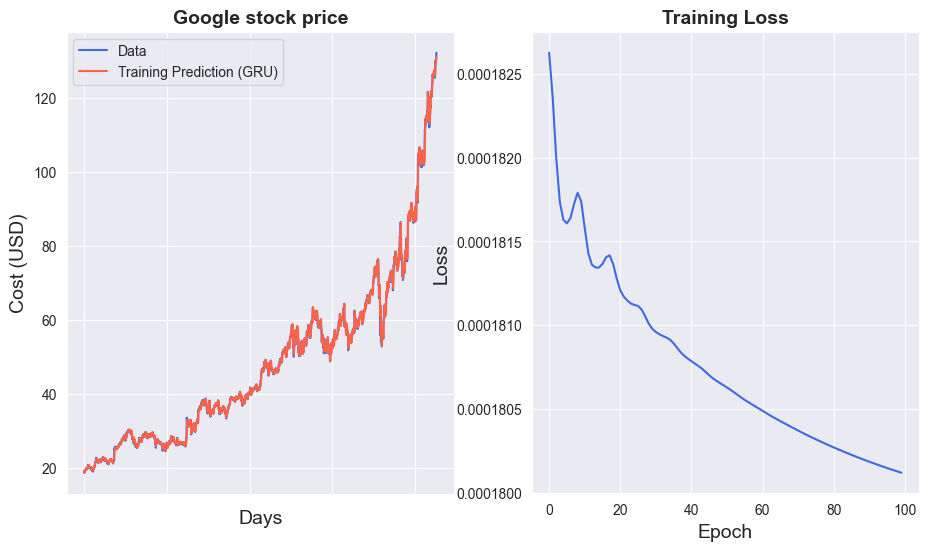

Train Score: 0.89 RMSE
Test Score: 2.53 RMSE


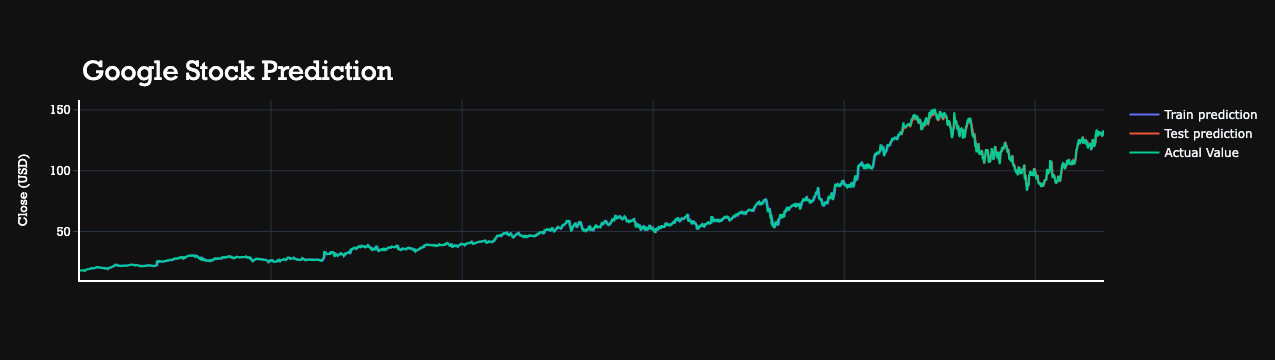

********* APPLE *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.00016274901281576604
Epoch  1 MSE:  0.00016306922771036625
Epoch  2 MSE:  0.00016493287694174796
Epoch  3 MSE:  0.00017325115913990885
Epoch  4 MSE:  0.00020750782277900726
Epoch  5 MSE:  0.00031975319143384695
Epoch  6 MSE:  0.000638017023447901
Epoch  7 MSE:  0.0011926661245524883
Epoch  8 MSE:  0.0021320555824786425
Epoch  9 MSE:  0.0021756410133093596
Epoch  10 MSE:  0.0016863065538927913
Epoch  11 MSE:  0.0003911259409505874
Epoch  12 MSE:  0.00038639010745100677
Epoch  13 MSE:  0.0011776997707784176
Epoch  14 MSE:  0.0007695875247009099
Epoch  15 MSE:  0.00019626409630291164
Epoch  16 MSE:  0.0005316503229551017
Epoch  17 MSE:  0.000668185472022742
Epoch  18 MSE:  0.000259849417489022
Epoch  19 MSE:  0.0003114315040875226
Epoch  20 MSE:  0.0005172648816369474
Epoch  21 MSE:  0.000266107585048303
Epoch  22 MSE:  0.0002519472618587315
Epoch  23 MSE:  0.000415

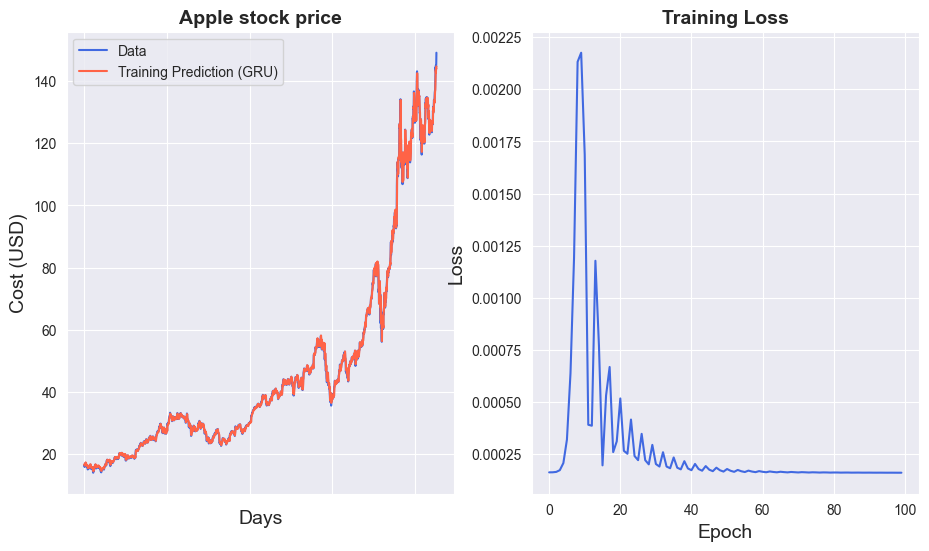

Train Score: 1.16 RMSE
Test Score: 3.70 RMSE


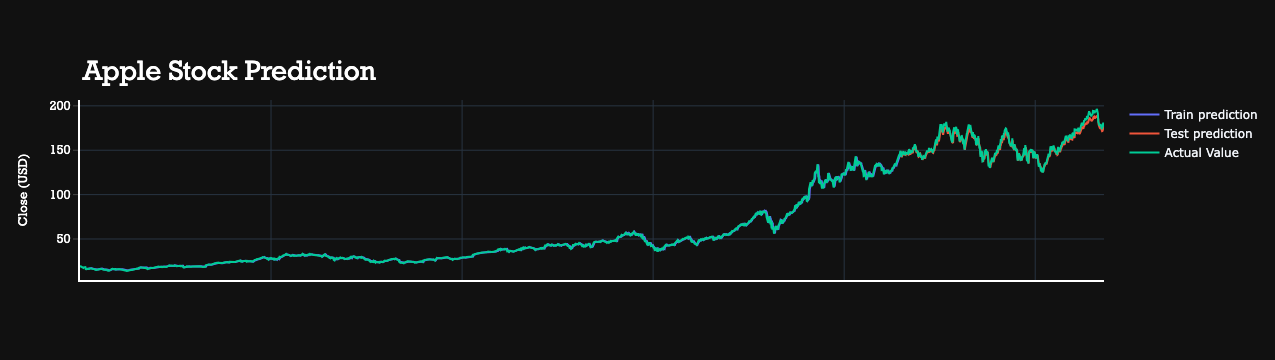

********* MICROSOFT *********
x_train: (2129, 19, 1) 
y_train: (2129, 1)
x_test: (532, 19, 1) 
y_test: (532, 1)
Epoch  0 MSE:  0.0001533455215394497
Epoch  1 MSE:  0.0001532634487375617
Epoch  2 MSE:  0.00015319314843509346
Epoch  3 MSE:  0.00015296782657969743
Epoch  4 MSE:  0.00015286277630366385
Epoch  5 MSE:  0.00015271216398105025
Epoch  6 MSE:  0.00015247830015141517
Epoch  7 MSE:  0.00015237514162436128
Epoch  8 MSE:  0.00015223580703604966
Epoch  9 MSE:  0.00015205815725494176
Epoch  10 MSE:  0.0001519661454949528
Epoch  11 MSE:  0.00015183626965153962
Epoch  12 MSE:  0.00015171003178693354
Epoch  13 MSE:  0.00015163944044616073
Epoch  14 MSE:  0.0001515183103037998
Epoch  15 MSE:  0.00015140537288971245
Epoch  16 MSE:  0.00015132878615986556
Epoch  17 MSE:  0.00015121202159207314
Epoch  18 MSE:  0.00015110131062101573
Epoch  19 MSE:  0.00015100288146641105
Epoch  20 MSE:  0.00015087529027368873
Epoch  21 MSE:  0.0001507622073404491
Epoch  22 MSE:  0.00015065430488903075
Epoch 

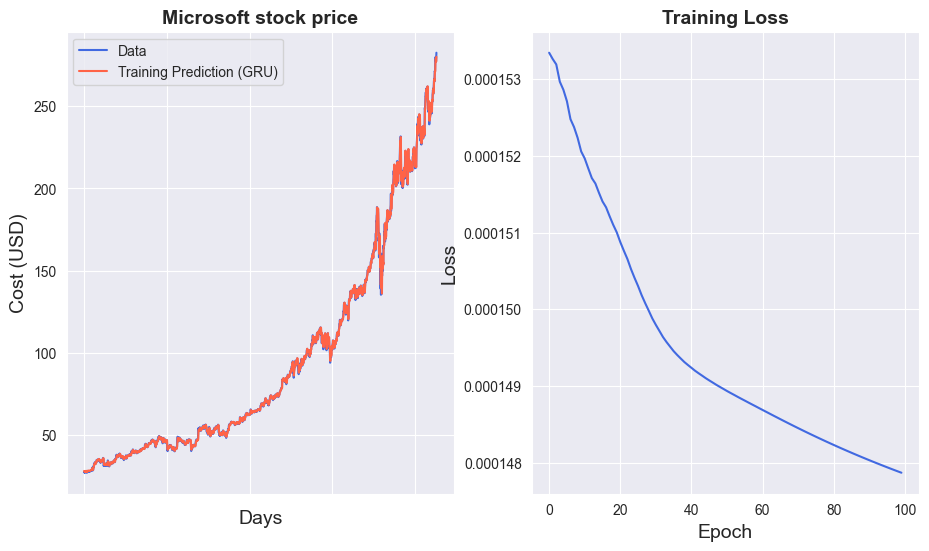

Train Score: 2.02 RMSE
Test Score: 6.16 RMSE


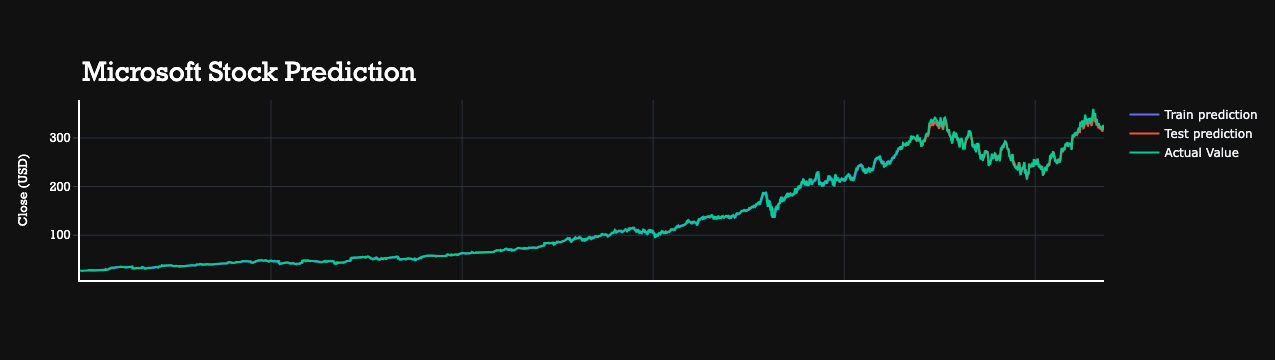

In [273]:
for data in dataset:
    print(colored(f'********* {data.upper()} *********','red'))
    
    # get the close value price we want to predict
    price = dataset[data][['Close']].reset_index(drop=True).copy()
    price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))

    # split dataset
    x_train, y_train, x_test, y_test = split_data(price, lookback)
    print(f'x_train: {x_train.shape} \ny_train: {y_train.shape}')
    print(f'x_test: {x_test.shape} \ny_test: {y_test.shape}')

    # convert to pytorch tensor
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

    # training process
    loss_history = np.zeros(num_epochs)
    start_time = time.time()
    
    for t in range(num_epochs):   
        y_train_pred = model(x_train)
        
        loss = criterion(y_train_pred, y_train_gru)
        print("Epoch ", t, "MSE: ", loss.item())
        loss_history[t] = loss.item()
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    print(f"Training time: {round(time.time()-start_time)}s")

    # plot the training results
    predicted_data = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
    original_data = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))
    plot_results(original_data, predicted_data, loss_history, data.capitalize())

    # make predictions
    y_test_pred = model(x_test)
    
    # invert predictions
    y_train_pred, y_train, y_test_pred, y_test = invert_predictions(y_train_pred, y_train_gru, y_test_pred, y_test_gru)
    
    # print score on train and test set
    print_scores(y_train_pred, y_train_gru, y_test_pred, y_test_gru, scaler)

    # generate a pandas dataframe to plot
    result_dataframe = format_dataframe(y_train_pred, y_test_pred, price, scaler, lookback)
    show_interactive_plot(result_dataframe, data.capitalize())

It can be seen from the various plots and results that the prediction is correct, for the 3 different companies